In [1]:
import numpy as np
import pandas as pd
from scipy.integrate import odeint
import matplotlib.pyplot as plt
plt.rcParams["text.usetex"] = True

In [2]:
#Fixed parameter values
pi = 1710; 
#beta1 =1.72;
mu =1/(83*365); 
eps =0.33;   #Youngji paper
tau = 0.8; tau = 0.8;
#psi = 0.5; 
phi1, phi2 = 1/180, 1/180
h1= 0.0012; 
h2 = (1-0.74)*h1;
rho = 1/14; rhot =1/10; rhoh =1/10;
eta1= 0.71; eta2= 0.41; eta4= 0.85; eta3 = 0.46;
#a = 1/3  # fixed to be 3 days  

# theta = 0.5 # parameter adjusting reduced perception risk (assumed)
# delta = 0.8  # proportion of tested people who quarantine/adhere to protective measures (assumed)
#alpha1, alpha2 = 0.5, 0.5  # parameters which shows to which information people are more concerned

# Dtilde, Btilde = 5, 5  # reactivity to information in vaccination
# D, B = 1*Dtilde, 1*Btilde # reactivity to information in testing (assumed equal)
Reac = 5;
Fmax = 0.027; 
#F10 = 0.0029; F20 = (0.9)*F10;
Tmax = 0.5; 
#T10 = 0.03; T20 = 0.03    #Tmax is adjusted to have a good fit

# Fitted parameters
k1=  0.51
# beta1=  0.67
# beta2=  0.39
xi=  0.99
d1 =0.000071; d2 = 0.000073;  

In [3]:
# Initial conditions
NN = 51815808
V2_0 = 2891 #int(0.87*Data_Omicron['new_vaccinations'].iloc[0])
V1_0 = 431; #int(0.13*Data_Omicron['new_vaccinations'].iloc[0])
E2_0 = 352645 #int(0.87*20*NewCases.iloc[0])
A2_0 = 70529 #int(0.2*E2_0)
I2_0 = 282116  #int(0.8*E2_0)
IT2_0 = 17632 #int(0.87*NewCases.iloc[0])
E1_0 = 52694 #int(0.13*20*NewCases.iloc[0])  # 0.13 indicates that 13% of the total population is in the first dynamics
A1_0 = 10538 #int(0.2*E1_0)
I1_0 = 42155 #int(0.8*E1_0)
IT1_0 = 2634 #int(0.13*NewCases.iloc[0])
H_0 = 202  # ICU
R_0 = 200
Dth_0 = 15
MV_0 = k1*((I1_0 + I2_0 + IT1_0 + IT2_0 + H_0)/NN)
MN_0 = k1*((H_0 + d1*(I1_0+I2_0) + d2*H_0)/NN)
S1_0 = 6615955
S2_0 = 40000000 
S3_0 = 4365186
x0 = [S1_0, S2_0, S3_0, V1_0, V2_0, E1_0, E2_0, A1_0, A2_0, I1_0, I2_0, IT1_0, IT2_0, H_0, R_0, Dth_0, MV_0, MN_0]

In [4]:
def deriv(x, t, beta1,beta2,k1,a,theta,alpha1,alpha2,delta,F10,F20,T10,psi, Reac_prev,Reac_sev):
    
    S1, S2, S3, V1, V2, E1, E2, A1, A2, I1, I2, I_T1, I_T2, H, R, Dth, MV, MN  = x
    dx = np.zeros(18)
    N= S1 + S2+ S3 + V1 + V2 + E1 + E2 + A1 + A2 + I1 + I2 + I_T1 + I_T2 + H + R
    
    T1 = T10 + (Tmax - T10)*(alpha1*(Reac_prev*MV)/(1+Reac_prev*MV) + (1-alpha1)*(Reac_sev*MN)/(1+Reac_sev*MN) )
    F1 = F10 + (Fmax - F10)*(alpha1*(Reac_prev*MV)/(1+Reac_prev*MV) + (1-alpha1)*(Reac_sev*MN)/(1+Reac_sev*MN))
    
    T2 = T10 + (Tmax - T10)*(alpha2*(theta*Reac_prev*MV)/(1+theta*Reac_prev*MV) + (1-alpha2)*(theta*Reac_sev*MN)/(1+theta*Reac_sev*MN))
    F2 = F20 + (Fmax - F20)*(alpha2*(theta*Reac_prev*MV)/(1+theta*Reac_prev*MV) + (1-alpha2)*(theta*Reac_sev*MN)/(1+theta*Reac_sev*MN))
    
    L1 = beta1*(I1 + I2 + psi*(A1 + A2) +(1-delta)*(I_T1 + I_T2))/(N-(delta*(I_T1 + I_T2) + H))
    L2 = beta2*(I1 + I2 + psi*(A1 + A2) +(1-delta)*(I_T1 + I_T2))/(N-(delta*(I_T1 + I_T2) + H))
    
    dx[0] = pi-(F1 +L1 +mu)*S1
    dx[1] = phi1*V1 -((1-eta2)*L2+F2+mu)*S2
    dx[2] = phi2*R-((1-eta3)*L2+F2+mu)*S3
    dx[3] = F1*S1-phi1*V1-(1-eta1)*L2*V1-mu*V1
    dx[4] = F2*S2+F2*S3-(1-eta4)*L2*V2-mu*V2
    dx[5] = L1*S1-(eps+mu)*E1
    dx[6] = (1-eta1)*L2*V1+(1-eta4)*L2*V2+L2*((1-eta2)*S2+(1-eta3)*S3)-(mu+eps)*E2
    dx[7] = (1-tau)*eps*E1-xi*T1*A1-(rho+mu)*A1
    dx[8] = (1-tau)*eps*E2-xi*T2*A2-(rho+mu)*A2
    dx[9] = tau*eps*E1-T1*I1-(rho+d1+mu)*I1
    dx[10] = tau*eps*E2-T2*I2-(rho+d1+mu)*I2
    dx[11] = xi*T1*A1+T1*I1-(rhot+h1+mu)*I_T1
    dx[12] = xi*T2*A2+T2*I2-(rhot+h2+mu)*I_T2
    dx[13] = h1*I_T1+h2*I_T2-rhoh*H-(d2+mu)*H
    dx[14] = rho*(A1+A2+I1+I2)+rhot*(I_T1+I_T2)+rhoh*H-(phi2+mu)*R
    dx[15] = d1*(I1+I2)+d2*H
    dx[16] = a*(k1*((I_T1+I_T2+I1+I2+H)/NN)-MV) 
    dx[17] = a*(k1*((H + d1*(I1 + I2) + d2*H)/NN)-MN)
    return dx

In [5]:
t = np.linspace(0, 200, 200)

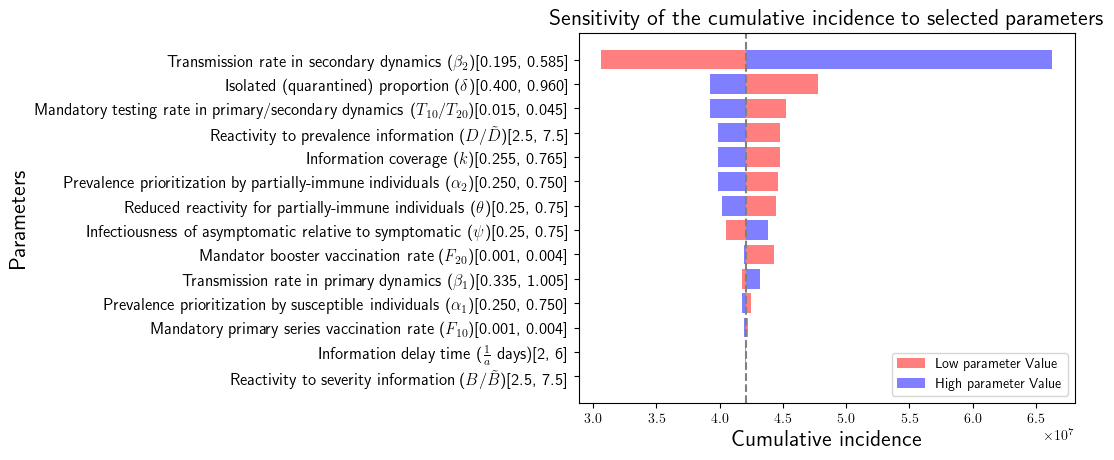

In [6]:
Cum_infectious1 = np.zeros(len(t));     Cum_infectious2 = np.zeros(len(t));
Cum_hosp1 = np.zeros(len(t));           Cum_hosp2 = np.zeros(len(t))
Cum_vacc1 = np.zeros(len(t));           Cum_vacc2 = np.zeros(len(t))
Cum_tested1 = np.zeros(len(t));         Cum_tested2 = np.zeros(len(t))
# SIR model implementation
def SIR_model(beta1,beta2,k1,a,theta,alpha1,alpha2,delta,F10,F20,T10,psi,Reac_prev,Reac_sev):       

    ret = odeint(deriv, x0, t, args=(beta1,beta2,k1,a,theta,alpha1,alpha2,delta,F10,F20,T10,psi,Reac_prev,Reac_sev))
    Active_cases =ret[:,7] + ret[:,9] + ret[:,8] + ret[:,10] 
    Peak_Active_cases = max(Active_cases)
    Cum_infectious1[0] = A1_0 + A2_0 + I1_0 + I2_0; Cum_tested1[0] = IT1_0 + IT2_0; Cum_hosp1[0] = H_0; Cum_vacc1[0] = V1_0 + V2_0
    
    for i0 in range(1,len(t)):
        Test1_1 = T10 + (Tmax -T10)*(alpha1* np.divide(Reac_prev*ret[:i0+1,16],(1+Reac_prev*ret[:i0+1,16])) + (1-alpha1)* np.divide(Reac_sev*ret[:i0+1,17],(1+Reac_sev*ret[:i0+1,17]))) 
        Test2_1 = T10 + (Tmax -T10)*(alpha2* np.divide(theta*Reac_prev*ret[:i0+1,16],(1+theta*Reac_prev*ret[:i0+1,16])) + (1-alpha2)* np.divide(theta*Reac_sev*ret[:i0+1,17],(1+theta*Reac_sev*ret[:i0+1,17])))

        Vac1_1 = F10 + (Fmax -F10)*(alpha1*np.divide(Reac_prev*ret[:i0+1,16],(1+Reac_prev*ret[:i0+1,16])) + (1-alpha1)*np.divide(Reac_sev*ret[:i0+1,17],(1+Reac_sev*ret[:i0+1,17])))
        Vac2_1 = F20 + (Fmax -F20)*(alpha2* np.divide(theta*Reac_prev*ret[:i0+1,16],(1+theta*Reac_prev*ret[:i0+1,16])) + (1-alpha2)* np.divide(theta*Reac_sev*ret[:i0+1,17],(1+theta*Reac_sev*ret[:i0+1,17])))
        
        Cum_infectious1[i0] = A1_0 + A2_0 + I1_0 + I2_0 + np.trapz(eps*(ret[:i0+1,5] + ret[:i0+1,6] ), t[:i0+1]) 
        Cum_hosp1[i0] = H_0 + np.trapz(h1*ret[:i0+1,11] + h2*ret[:i0+1,12], t[:i0+1])
        Cum_vacc1[i0] = V1_0 + V2_0 + np.trapz(np.multiply(Vac1_1,ret[:i0+1,0]) + np.multiply(Vac2_1,(ret[:i0+1,1]+ret[:i0+1,2])),t[:i0+1])  
        Cum_tested1[i0] = IT1_0 + IT2_0 + np.trapz(np.multiply(Test1_1,(xi*ret[:i0+1,7]+ ret[:i0+1,9])) + np.multiply(Test2_1,(xi*ret[:i0+1,8]+ ret[:i0+1,10])),t[:i0+1]) 

    Final_CumIncidence = Cum_infectious1[-1]
    #Cost over the cumulative 
    Hosp_treatment_cost = 557.3*(1/rhoh)*Cum_hosp1[-1]   # $557.3 - average daily cost of treatment in hospital, 1/rhoh - period spent in hospital before recovery,  
    Out_patient_treatment_cost = 50.5*(1/rhot)*(0.2*Cum_tested1[-1]) # $50.5 - average daily Outpatient treatment, we assumed 20% of tested people take this treatment, 1/rhot is recovery period
    Medical_treatment_cost = Hosp_treatment_cost + Out_patient_treatment_cost
    
    Vaccination_cost = 35.76*Cum_vacc1[-1]  # $35.76 is vaccination cost/person = vaccination cost ($17.89) + vaccination procedure cost($16.87) + logistic cost ($1)
    Testing_cost = 25.41*Cum_tested1[-1]  # The cost for Rapid Antigin Test (RAT) in South Korea from 20,000 to 50,000 Won. We take the averge 35,000 won == $25.41, PCR test 60000 - 80000, average = $50.56
    
    Total_cost = Medical_treatment_cost + Vaccination_cost + Testing_cost
   # Return the cumulative incidence and total cost
    return Final_CumIncidence, Total_cost, Peak_Active_cases

# Define the baseline values for the parameters
baseline_Reac_prev,baseline_Reac_sev = 5, 5;
baseline_beta1 =  0.67; baseline_beta2=  0.39
baseline_k1 = 0.51; baseline_a = 0.33; baseline_theta = 0.5
baseline_alpha1 = 0.5; baseline_alpha2 = 0.5
baseline_delta = 0.8; 
baseline_F10 = 0.0029; baseline_F20 = (0.9)*baseline_F10;
baseline_T10 = 0.03; 
baseline_psi = 0.5;

# Low and high values for sensitivity analysis
pmin = 0.5; pmax = 1.5;
parameters = {
    'beta1': (pmin*baseline_beta1, pmax*baseline_beta1),
    'beta2': ( pmin*baseline_beta2, pmax*baseline_beta2),
    'k1': (pmin*baseline_k1, pmax*baseline_k1),
    'a': ( pmax*baseline_a, pmin*baseline_a),
    'theta': (pmin*baseline_theta, pmax*baseline_theta),
    'alpha1': (pmin*baseline_alpha1, pmax*baseline_alpha1),
    'alpha2': (pmin*baseline_alpha2, pmax*baseline_alpha2),
    'delta': (pmin*baseline_delta, 1.2*baseline_delta),
    'F10': (pmin*baseline_F10, pmax*baseline_F10),
    'F20': (pmin*baseline_F20, pmax*baseline_F20),
    'T10': (pmin*baseline_T10, pmax*baseline_T10),
    'psi': (pmin*baseline_psi, pmax*baseline_psi),
    'Reac_prev': (pmin*baseline_Reac_prev, pmax*baseline_Reac_prev),
    'Reac_sev': (pmin*baseline_Reac_sev, pmax*baseline_Reac_sev),
    # 'Prev_sev': (0,1)
}
# Parameter descriptions
param_descriptions = {    
    'beta1': rf'Transmission rate in primary dynamics ($\beta_1$)[{pmin*baseline_beta1:.3f}, {pmax*baseline_beta1:.3f}]',
    'beta2': rf'Transmission rate in secondary dynamics ($\beta_2$)[{pmin*baseline_beta2:.3f}, {pmax*baseline_beta2:.3f}]',
    'k1': rf'Information coverage ($k$)[{pmin*baseline_k1:.3f}, {pmax*baseline_k1:.3f}]',
    'a': rf'Information delay time ($\frac{1}{{a}}$ days)[{(1/(pmax*baseline_a)):.0f}, {(1/(pmin*baseline_a)):.0f}]',
    'theta': rf'Reduced reactivity for partially-immune individuals ($\theta$)[{pmin*baseline_theta:.2f}, {pmax*baseline_theta:.2f}]',
    'alpha1': rf'Prevalence prioritization by susceptible individuals ($\alpha_1$)[{pmin*baseline_alpha1:.3f}, {pmax*baseline_alpha1:.3f}]',
    'alpha2': rf'Prevalence prioritization by partially-immune individuals ($\alpha_2$)[{pmin*baseline_alpha2:.3f}, {pmax*baseline_alpha2:.3f}]',
    'delta': rf'Isolated (quarantined) proportion ($\delta$)[{pmin*baseline_delta:.3f}, {1.2*baseline_delta:.3f}]',
    'F10': rf'Mandatory primary series vaccination rate  ($F_{{10}}$)[{pmin*baseline_F10:.3f}, {pmax*baseline_F10:.3f}]',
    'F20': rf'Mandator booster vaccination rate ($F_{{20}}$)[{pmin*baseline_F20:.3f}, {pmax*baseline_F20:.3f}]',
    'T10': rf'Mandatory testing rate in primary/secondary dynamics ($T_{{10}}/T_{{20}}$)[{pmin*baseline_T10:.3f}, {pmax*baseline_T10:.3f}]',
    'psi': rf'Infectiousness of asymptomatic relative to symptomatic ($\psi$)[{pmin*baseline_psi:.2f}, {pmax*baseline_psi:.2f}]',
    'Reac_prev': rf'Reactivity to prevalence information  ($D/\tilde D$)[{pmin*baseline_Reac_prev:.1f}, {pmax*baseline_Reac_prev:.1f}]',
    'Reac_sev': rf'Reactivity to severity information  ($B/\tilde B$)[{pmin*baseline_Reac_sev:.1f}, {pmax*baseline_Reac_sev:.1f}]',
    # 'Prev_sev': rf'Risk factor switch (severity, prevalence)  ($\alpha_1 \& \alpha_2$)[0, 1]'

}

# Integrate the SIR model for the base case
Base_CI, Base_TotalCost,Base_Peak_Active_cases = SIR_model(baseline_beta1,baseline_beta2, baseline_k1,baseline_a,baseline_theta,baseline_alpha1,baseline_alpha2,baseline_delta,baseline_F10,baseline_F20,baseline_T10,baseline_psi,baseline_Reac_prev,baseline_Reac_sev)

# Sensitivity analysis
sensitivity_results = {}

for param, (low, high) in parameters.items():
    if param == 'beta1':
        CI_low, TC_low,Peak_Active_cases_low = SIR_model(low,baseline_beta2,baseline_k1,baseline_a,baseline_theta,baseline_alpha1,baseline_alpha2,baseline_delta,baseline_F10,baseline_F20,baseline_T10,baseline_psi,baseline_Reac_prev,baseline_Reac_sev)
        CI_high, TC_high,Peak_Active_cases_high = SIR_model(high,baseline_beta2,baseline_k1,baseline_a,baseline_theta,baseline_alpha1,baseline_alpha2,baseline_delta,baseline_F10,baseline_F20,baseline_T10,baseline_psi,baseline_Reac_prev,baseline_Reac_sev)
    elif param == 'beta2':
        CI_low, TC_low,Peak_Active_cases_low = SIR_model(baseline_beta1,low,baseline_k1,baseline_a,baseline_theta,baseline_alpha1,baseline_alpha2,baseline_delta,baseline_F10,baseline_F20,baseline_T10,baseline_psi,baseline_Reac_prev,baseline_Reac_sev)
        CI_high, TC_high,Peak_Active_cases_high = SIR_model(baseline_beta1,high,baseline_k1,baseline_a,baseline_theta,baseline_alpha1,baseline_alpha2,baseline_delta,baseline_F10,baseline_F20,baseline_T10,baseline_psi,baseline_Reac_prev,baseline_Reac_sev)
    if param == 'k1':
        CI_low, TC_low,Peak_Active_cases_low = SIR_model(baseline_beta1,baseline_beta2,low,baseline_a,baseline_theta,baseline_alpha1,baseline_alpha2,baseline_delta,baseline_F10,baseline_F20,baseline_T10,baseline_psi,baseline_Reac_prev,baseline_Reac_sev)
        CI_high, TC_high,Peak_Active_cases_high = SIR_model(baseline_beta1,baseline_beta2,high,baseline_a,baseline_theta,baseline_alpha1,baseline_alpha2,baseline_delta,baseline_F10,baseline_F20,baseline_T10,baseline_psi,baseline_Reac_prev,baseline_Reac_sev)
    elif param == 'a':
        CI_low, TC_low,Peak_Active_cases_low = SIR_model(baseline_beta1,baseline_beta2,baseline_k1,low,baseline_theta,baseline_alpha1,baseline_alpha2,baseline_delta,baseline_F10,baseline_F20,baseline_T10,baseline_psi,baseline_Reac_prev,baseline_Reac_sev)
        CI_high, TC_high,Peak_Active_cases_high = SIR_model(baseline_beta1,baseline_beta2,baseline_k1,high,baseline_theta,baseline_alpha1,baseline_alpha2,baseline_delta,baseline_F10,baseline_F20,baseline_T10,baseline_psi,baseline_Reac_prev,baseline_Reac_sev)
    elif param == 'theta':
        CI_low, TC_low,Peak_Active_cases_low = SIR_model(baseline_beta1,baseline_beta2,baseline_k1,baseline_a,low,baseline_alpha1,baseline_alpha2,baseline_delta,baseline_F10,baseline_F20,baseline_T10,baseline_psi,baseline_Reac_prev,baseline_Reac_sev)
        CI_high, TC_high,Peak_Active_cases_high = SIR_model(baseline_beta1,baseline_beta2,baseline_k1,baseline_a,high,baseline_alpha1,baseline_alpha2,baseline_delta,baseline_F10,baseline_F20,baseline_T10,baseline_psi,baseline_Reac_prev,baseline_Reac_sev)
    elif param == 'alpha1':
        CI_low, TC_low,Peak_Active_cases_low = SIR_model(baseline_beta1,baseline_beta2,baseline_k1,baseline_a,baseline_theta,low,baseline_alpha2,baseline_delta,baseline_F10,baseline_F20,baseline_T10,baseline_psi,baseline_Reac_prev,baseline_Reac_sev)
        CI_high, TC_high,Peak_Active_cases_high = SIR_model(baseline_beta1,baseline_beta2,baseline_k1,baseline_a,baseline_theta,high,baseline_alpha2,baseline_delta,baseline_F10,baseline_F20,baseline_T10,baseline_psi,baseline_Reac_prev,baseline_Reac_sev)
    elif param == 'alpha2':
        CI_low, TC_low,Peak_Active_cases_low = SIR_model(baseline_beta1,baseline_beta2,baseline_k1,baseline_a,baseline_theta,baseline_alpha1,low,baseline_delta,baseline_F10,baseline_F20,baseline_T10,baseline_psi,baseline_Reac_prev,baseline_Reac_sev)
        CI_high, TC_high,Peak_Active_cases_high = SIR_model(baseline_beta1,baseline_beta2,baseline_k1,baseline_a,baseline_theta,baseline_alpha1,high,baseline_delta,baseline_F10,baseline_F20,baseline_T10,baseline_psi,baseline_Reac_prev,baseline_Reac_sev)
    elif param == 'delta':
        CI_low, TC_low,Peak_Active_cases_low = SIR_model(baseline_beta1,baseline_beta2,baseline_k1,baseline_a,baseline_theta,baseline_alpha1,baseline_alpha2,low,baseline_F10,baseline_F20,baseline_T10,baseline_psi,baseline_Reac_prev,baseline_Reac_sev)
        CI_high, TC_high,Peak_Active_cases_high = SIR_model(baseline_beta1,baseline_beta2,baseline_k1,baseline_a,baseline_theta,baseline_alpha1,baseline_alpha2,high,baseline_F10,baseline_F20,baseline_T10,baseline_psi,baseline_Reac_prev,baseline_Reac_sev)
    elif param == 'F10':
        CI_low, TC_low,Peak_Active_cases_low = SIR_model(baseline_beta1,baseline_beta2,baseline_k1,baseline_a,baseline_theta,baseline_alpha1,baseline_alpha2,baseline_delta,low,baseline_F20,baseline_T10,baseline_psi,baseline_Reac_prev,baseline_Reac_sev)
        CI_high, TC_high,Peak_Active_cases_high = SIR_model(baseline_beta1,baseline_beta2,baseline_k1,baseline_a,baseline_theta,baseline_alpha1,baseline_alpha2,baseline_delta,high,baseline_F20,baseline_T10,baseline_psi,baseline_Reac_prev,baseline_Reac_sev)
    elif param == 'F20':
        CI_low, TC_low,Peak_Active_cases_low = SIR_model(baseline_beta1,baseline_beta2,baseline_k1,baseline_a,baseline_theta,baseline_alpha1,baseline_alpha2,baseline_delta,baseline_F10,low,baseline_T10,baseline_psi,baseline_Reac_prev,baseline_Reac_sev)
        CI_hgh, TC_high,Peak_Active_cases_high = SIR_model(baseline_beta1,baseline_beta2,baseline_k1,baseline_a,baseline_theta,baseline_alpha1,baseline_alpha2,baseline_delta,baseline_F10,high,baseline_T10,baseline_psi,baseline_Reac_prev,baseline_Reac_sev)
    elif param == 'T10':
        CI_low, TC_low,Peak_Active_cases_low = SIR_model(baseline_beta1,baseline_beta2,baseline_k1,baseline_a,baseline_theta,baseline_alpha1,baseline_alpha2,baseline_delta,baseline_F10,baseline_F20,low,baseline_psi,baseline_Reac_prev,baseline_Reac_sev)
        CI_high, TC_high,Peak_Active_cases_high = SIR_model(baseline_beta1,baseline_beta2,baseline_k1,baseline_a,baseline_theta,baseline_alpha1,baseline_alpha2,baseline_delta,baseline_F10,baseline_F20,high,baseline_psi,baseline_Reac_prev,baseline_Reac_sev)
    elif param == 'psi':
        CI_low, TC_low,Peak_Active_cases_low = SIR_model(baseline_beta1,baseline_beta2,baseline_k1,baseline_a,baseline_theta,baseline_alpha1,baseline_alpha2,baseline_delta,baseline_F10,baseline_F20,baseline_T10,low,baseline_Reac_prev,baseline_Reac_sev)
        CI_high, TC_high,Peak_Active_cases_high = SIR_model(baseline_beta1,baseline_beta2,baseline_k1,baseline_a,baseline_theta,baseline_alpha1,baseline_alpha2,baseline_delta,baseline_F10,baseline_F20,baseline_T10,high,baseline_Reac_prev,baseline_Reac_sev)
    elif param == 'Reac_prev':
        CI_low, TC_low,Peak_Active_cases_low = SIR_model(baseline_beta1,baseline_beta2,baseline_k1,baseline_a,baseline_theta,baseline_alpha1,baseline_alpha2,baseline_delta,baseline_F10,baseline_F20,baseline_T10,baseline_psi,low,baseline_Reac_sev)
        CI_high, TC_high,Peak_Active_cases_high = SIR_model(baseline_beta1,baseline_beta2,baseline_k1,baseline_a,baseline_theta,baseline_alpha1,baseline_alpha2,baseline_delta,baseline_F10,baseline_F20,baseline_T10,baseline_psi,high,baseline_Reac_sev)
    elif param == 'Reac_sev':
        CI_low, TC_low,Peak_Active_cases_low = SIR_model(baseline_beta1,baseline_beta2,baseline_k1,baseline_a,baseline_theta,baseline_alpha1,baseline_alpha2,baseline_delta,baseline_F10,baseline_F20,baseline_T10,baseline_psi,baseline_Reac_prev,low)
        CI_high, TC_high,Peak_Active_cases_high = SIR_model(baseline_beta1,baseline_beta2,baseline_k1,baseline_a,baseline_theta,baseline_alpha1,baseline_alpha2,baseline_delta,baseline_F10,baseline_F20,baseline_T10,baseline_psi,baseline_Reac_prev,high)
    # elif param == 'Prev_sev':
    #     CI_low, TC_low,Peak_Active_cases_low = SIR_model(baseline_beta1,baseline_beta2,baseline_k1,baseline_a,baseline_theta,0,0,baseline_delta,baseline_F10,baseline_F20,baseline_T10,baseline_psi,baseline_Reac_prev,baseline_Reac_sev)
    #     CI_high, TC_high,Peak_Active_cases_high = SIR_model(baseline_beta1,baseline_beta2,baseline_k1,baseline_a,baseline_theta,1,1,baseline_delta,baseline_F10,baseline_F20,baseline_T10,baseline_psi,baseline_Reac_prev,baseline_Reac_sev)    
    
    sensitivity_results[param] = (CI_low, CI_high)
    #sensitivity_results[param] = (Peak_Active_cases_low, Peak_Active_cases_high)
    
# Sort the parameters by the length of their bars
sorted_params = sorted(sensitivity_results.keys(), key=lambda param: abs(sensitivity_results[param][1] - sensitivity_results[param][0]))

# Plotting the tornado plot
labels = [param_descriptions[param] for param in sorted_params]
base_values = [Base_CI] * len(labels)
#base_values = [Base_Peak_Active_cases] * len(labels)
low_values = [sensitivity_results[param][0] for param in sorted_params]
high_values = [sensitivity_results[param][1] for param in sorted_params]

# Calculate the differences
low_diffs = [base - low for base, low in zip(base_values, low_values)]
high_diffs = [high - base for high, base in zip(high_values, base_values)]


fig, ax = plt.subplots()

# for i, (low, high) in enumerate(zip(low_values, high_values)):
#     ax.barh(labels[i],base_values[i]-low, left = base_values[i], color = 'red', alpha=0.5, label='Low Value' if i==0 else "")
#     ax.barh(labels[i],high - base_values[i], left = high_values[i], color = 'blue', alpha=0.5, label='High Value' if i == 0 else "")
    # if low > base_values[i]:
    #     ax.barh(labels[i],base_values[i]-low, left = low_values[i], color = 'red', alpha=0.5, label='Low Value')
    # elif low
    # elif high == high_values[i]:
    #     ax.barh(labels[i],high - base_values[i], left = base_values[i], color = 'blue', alpha=0.5, label='High Value')

# Plot bars for low values
for i, (low, diff) in enumerate(zip(low_values, low_diffs)):
    
    ax.barh(labels[i], -diff if diff < 0 else 0, left=base_values[i], color='red', alpha=0.5, label='Low parameter Value' if i == 0 else "")
    ax.barh(labels[i], diff if diff > 0 else 0, left=base_values[i] + (-diff if diff < 0 else 0), color='blue', alpha=0.5)

#Plot bars for high values
for i, (high, diff) in enumerate(zip(high_values, high_diffs)):
       
    ax.barh(labels[i], diff if diff < 0 else 0, left = base_values[i], color='blue', alpha=0.5, label='High parameter Value' if i == 0 else "")
    ax.barh(labels[i], -diff if diff > 0 else 0, left = base_values[i], color='red', alpha=0.5)


# ax.barh(labels, [base - low for base, low in zip(base_values, low_values)], left=low_values, color='blue', alpha=0.5, label='Low Value')
# ax.barh(labels, [high - base for high, base in zip(high_values, base_values)], left=base_values, color='red', alpha=0.5, label='High Value')
ax.axvline(Base_CI, color='grey', linestyle='--')

#ax.set_xlabel('Cumulative Incidence')
ax.set_xlabel('Cumulative incidence',fontsize=16)
ax.set_ylabel('Parameters',fontsize=16)
plt.yticks(fontsize = 12)
ax.set_title('Sensitivity of the cumulative incidence to selected parameters',fontsize=16)
ax.legend(loc = 'lower right')
plt.savefig('SensitivityCI1_1.png', bbox_inches='tight', pad_inches=0.1, dpi =600)
plt.show()

In [7]:
Base_CI

42067196.88438433

In [8]:
42067196-17846451

24220745